### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import yfinance
import matplotlib.pyplot as plt

start_date = "2017-01-01"
end_date = "2023-06-01"
symbol = "IOC.NS"

df = yfinance.download(tickers = symbol,start="2010-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2010-03-08,26.707164,26.767482,26.375425,26.508984,3420936
2010-03-09,26.590840,26.668389,26.207400,26.315109,2820648
2010-03-10,26.160011,26.444360,26.069537,26.349577,2508072
2010-03-11,26.452974,26.625308,25.983369,26.220327,3387942
2010-03-12,26.280639,26.323721,26.030757,26.172932,1900506
...,...,...,...,...,...
2023-08-25,91.949997,93.199997,91.650002,91.800003,7021529
2023-08-28,92.250000,92.500000,91.699997,91.900002,6866040
2023-08-29,92.050003,92.400002,91.599998,91.900002,6510089


In [2]:
import pandas as pd

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3332.0,5.102892e+01,2.250705e+01,17.818321,2.974539e+01,4.440179e+01,7.188525e+01,9.968763e+01
High,3332.0,5.168276e+01,2.270372e+01,18.271844,3.018795e+01,4.508030e+01,7.281437e+01,1.006552e+02
Low,3332.0,5.029449e+01,2.221799e+01,17.392853,2.922373e+01,4.373218e+01,7.080743e+01,9.741558e+01
Close,3332.0,5.092838e+01,2.243970e+01,18.038071,2.970037e+01,4.435009e+01,7.171185e+01,9.886143e+01
Volume,3332.0,1.315732e+07,1.503976e+07,0.000000,4.272738e+06,9.178098e+06,1.661632e+07,3.148937e+08


In [4]:
df1 = df.reset_index()['Close']

In [5]:
df1

0       26.508984
1       26.315109
2       26.349577
3       26.220327
4       26.172932
          ...    
3327    91.800003
3328    91.900002
3329    91.900002
3330    90.750000
3331    89.500000
Name: Close, Length: 3332, dtype: float64

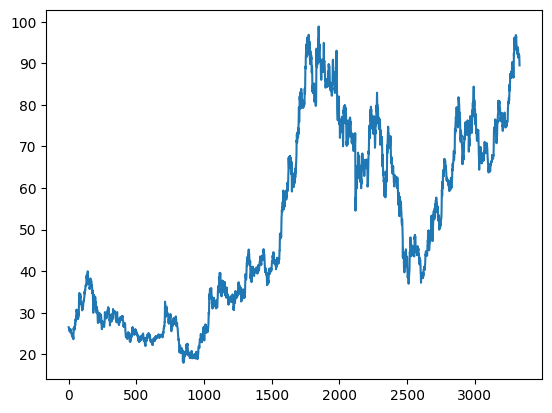

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [7]:
import numpy as np

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
print(df1)

[[0.10480773]
 [0.10240899]
 [0.10283545]
 ...
 [0.91386864]
 [0.89964006]
 [0.88417423]]


In [10]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size= len(df1) - training_size
train_data,test_data= df1[0:training_size,:] , df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(2165, 1167)

In [12]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [13]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
print(X_test.shape), print(ytest.shape)

(1066, 100)
(1066,)


(None, None)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

2023-08-31 12:14:46.088584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
33/33 [==============================] - 12s 232ms/step - loss: 0.0237 - val_loss: 0.0036
Epoch 2/10
33/33 [==============================] - 7s 201ms/step - loss: 0.0015 - val_loss: 9.6555e-04
Epoch 3/10
33/33 [==============================] - 6s 196ms/step - loss: 9.3509e-04 - val_loss: 9.0063e-04
Epoch 4/10
33/33 [==============================] - 6s 189ms/step - loss: 9.1304e-04 - val_loss: 9.0680e-04
Epoch 5/10
33/33 [==============================] - 7s 224ms/step - loss: 9.0197e-04 - val_loss: 8.5295e-04
Epoch 6/10
33/33 [==============================] - 7s 214ms/step - loss: 8.6489e-04 - val_loss: 9.4421e-04
Epoch 7/10
33/33 [==============================] - 7s 205ms/step - loss: 8.3827e-04 - val_loss: 8.0059e-04
Epoch 8/10
33/33 [==============================] - 6s 196ms/step - loss: 8.9606e-04 - val_loss: 9.9811e-04
Epoch 9/10
33/33 [==============================] - 8s 254ms/step - loss: 8.3202e-04 - val_loss: 7.5366e-04
Epoch 10/10
33/33 [====================

In [22]:
import tensorflow as tf

In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

34/34 [==============================] - 3s 88ms/step


In [24]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

In [25]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

49.42487779095012

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

66.63568562536813

In [29]:
indexs = df.index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


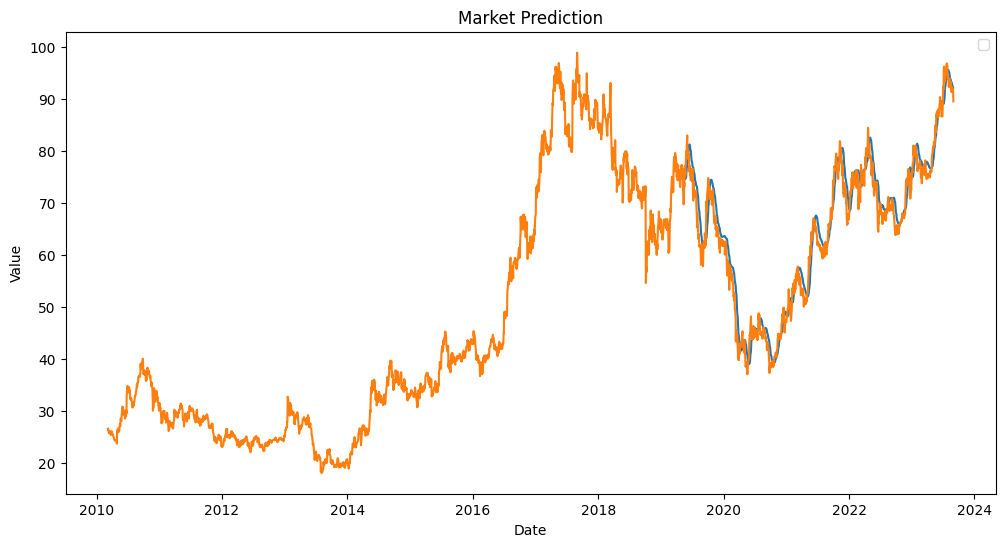

In [30]:
# shift test predictions for plotting
look_back =100
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

test_df = pd.DataFrame({"close" :testPredictPlot[:,0] ,"date" : indexs })
test_df['date'] = pd.to_datetime(test_df['date'])

# Set the 'Date' column as the index
test_df.set_index('date', inplace=True)
#test_df.plot(figsize=(12, 6))


plt.figure(figsize=(12, 6))  # Width: 8 inches, Height: 6 inches
plt.plot(test_df)
#plt.plot(trained_df)
plt.plot(df[["Close"]])


plt.title('Market Prediction')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()  # Show legend with labels
plt.show()

In [33]:
test_df.tail(1)

,close
date,
2023-08-31,NaN


In [ ]:
len(test_data)

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)